# Pokemon Image Classification

add an introduction paragraph here or something

## Package Import

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2

## Merging Data

In [79]:
train_dir = "data/images/images/"
train_path = Path(train_dir)

# Creating a dataframe with the name and filepath of each Pokemon
files = list(train_path.glob("*.png"))
names = [os.path.split(filename)[1] for filename in files]
image_df = pd.concat(
    [pd.Series(names, name="Name"), pd.Series(files, name="Filepath").astype(str)],
    axis=1,
)
image_df["Name"] = image_df["Name"].apply(lambda x: re.sub(r"\.\w+$", "", x))

# Importing label_df
label_df = pd.read_csv("data/pokemon.csv")

# Merging so we have one dataframe with pokemon information and filepath to image
df = image_df.merge(label_df, on="Name")

df.head()

,Name,Filepath,Type1,Type2
0,abomasnow,data\images\images\abomasnow.png,Grass,Ice
1,abra,data\images\images\abra.png,Psychic,NaN
2,absol,data\images\images\absol.png,Dark,NaN
3,accelgor,data\images\images\accelgor.png,Bug,NaN
4,aegislash-blade,data\images\images\aegislash-blade.png,Steel,Ghost


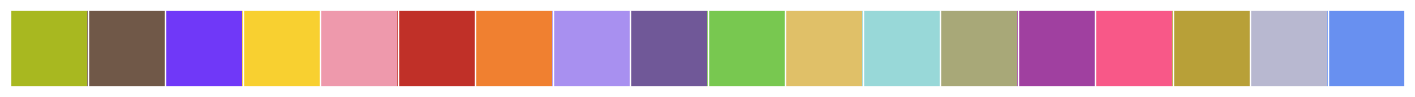

In [80]:
custom_colors = {
    "Bug": "#a8b820",
    "Dark": "#705848",
    "Dragon": "#7038f8",
    "Electric": "#f8d030",
    "Fairy": "#ee99ac",
    "Fighting": "#c03028",
    "Fire": "#f08030",
    "Flying": "#a890f0",
    "Ghost": "#705898",
    "Grass": "#78c850",
    "Ground": "#e0c068",
    "Ice": "#98d8d8",
    "Normal": "#a8a878",
    "Poison": "#a040a0",
    "Psychic": "#f85888",
    "Rock": "#b8a038",
    "Steel": "#b8b8d0",
    "Water": "#6890f0",
}

sns.set(font_scale=1.25)
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()), size=1)

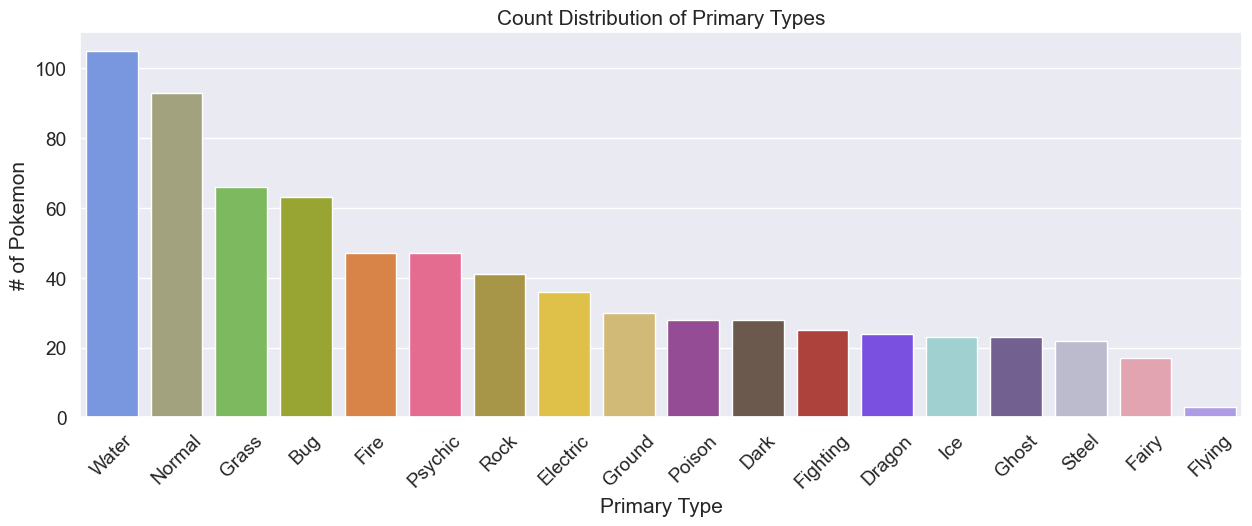

In [81]:
# Find the number of each type of pokemon
type1_data = (
    df["Type1"].value_counts().rename_axis("Type1").reset_index(name="# of Pokemon")
)

# Plot number of each type of pokemon with custom colors
plt.figure(figsize=(15, 5))
plt.title("Count Distribution of Primary Types")
ax = sns.barplot(x="Type1", y="# of Pokemon", data=type1_data, palette=custom_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
ax.set_xlabel("Primary Type")
plt.show()

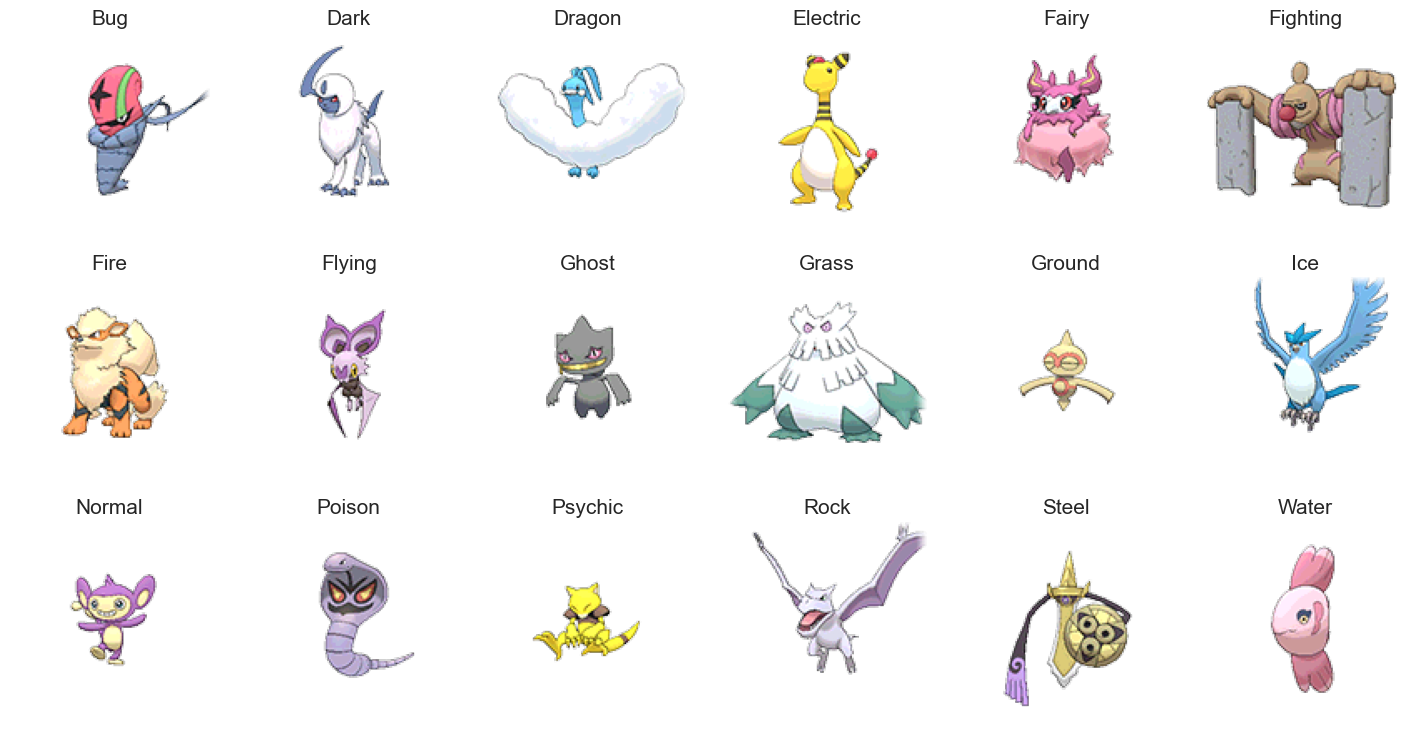

In [82]:
# Getting examples of pokemon of each type
type1 = list(custom_colors.keys())
first_row_indices = []
for type in type1:
    first_row_indices.append(df[df["Type1"] == type].index[0])

# Get images from filepaths
imgs = []
for index in first_row_indices:
    imgs.append(mpimg.imread(df.iat[index, 1]))

# Displaying an example of each pokemon primary type
f, axarr = plt.subplots(3, 6, figsize=(18, 9))
count = 0
for r in range(3):
    for c in range(6):
        axarr[r, c].imshow(imgs[count])
        axarr[r, c].set_title(type1[count])
        axarr[r, c].set_axis_off()
        count += 1

plt.show()

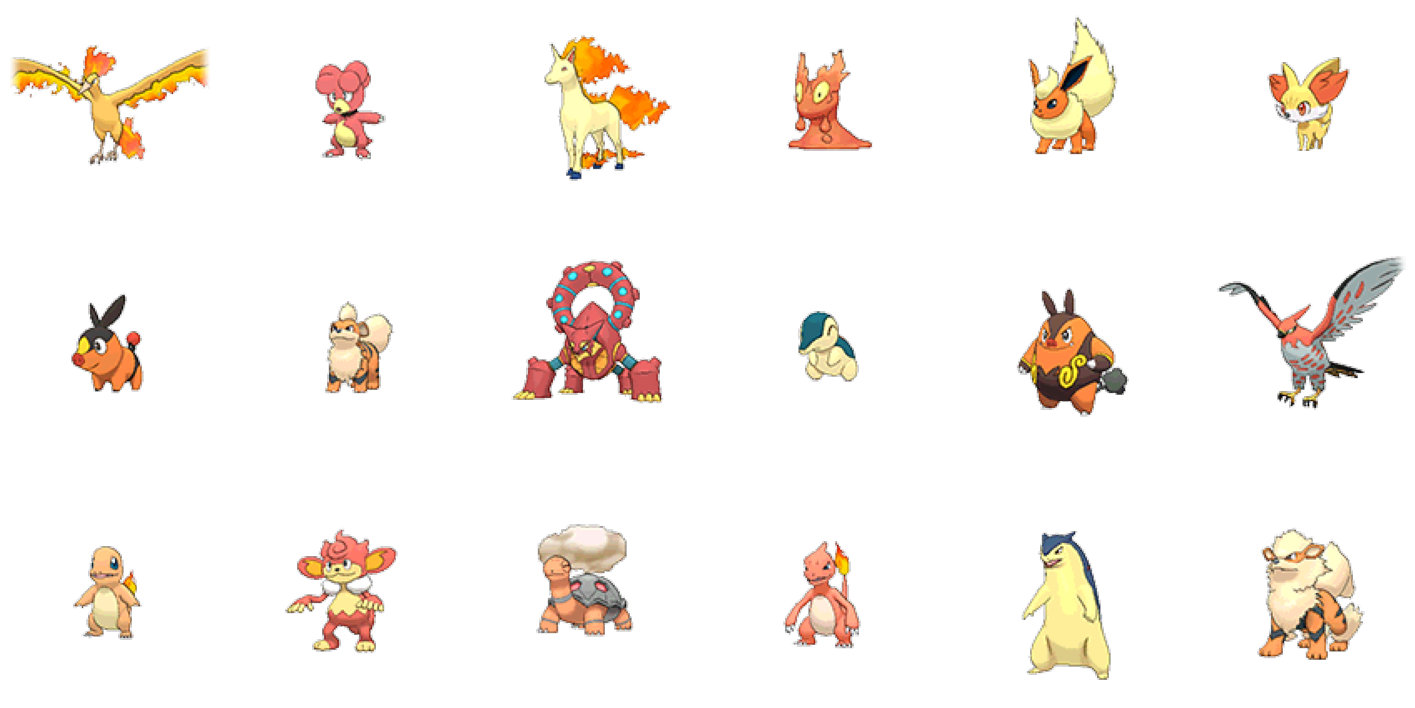

In [109]:
# Showing how appearances change within a single type
water_indices = []
for i in range(len(df.index)):
    if df.iat[i, 2] == "Fire":
        water_indices.append(i)

water_imgs = []
for index in water_indices:
    water_imgs.append(mpimg.imread(df.iat[index, 1]))

f, axarr = plt.subplots(3, 6, figsize=(18, 9))
count = 0
for r in range(3):
    for c in range(6):
        axarr[r, c].imshow(water_imgs[count])
        axarr[r, c].set_axis_off()
        count += 1

plt.show()

## Data Preprocessing

In [84]:
df = df.query("Type1 == 'Fire' | Type1 == 'Water'")

print("Number of water-types:", len(df[df['Type1'] == 'Water']))
print("Number of fire-types:", len(df[df['Type1'] == 'Fire']))

Number of water-types: 105
Number of fire-types: 47


### Train Test Split

In [85]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1./255          # rescale the rgb values to fit between 0 and 1 
)


train_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation'
)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


## Modeling

### Model Architecture

In [86]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',                 
    loss='binary_crossentropy',
    metrics=['acc', keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 256)       2097

## Training Loop / Fitting Model

In [87]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 1.1683 - acc: 0.4672 - auc_1: 0.5621 - val_loss: 0.6828 - val_acc: 0.6000 - val_auc_1: 0.1991 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 0.6102 - acc: 0.7131 - auc_1: 0.5949 - val_loss: 0.6440 - val_acc: 0.6000 - val_auc_1: 0.9653 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 0.5886 - acc: 0.7459 - auc_1: 0.8562 - val_loss: 0.5091 - val_acc: 0.6667 - val_auc_1: 0.9815 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 0.3709 - acc: 0.8361 - auc_1: 0.9123 - val_loss: 0.7254 - val_acc: 0.7333 - val_auc_1: 0.9861 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 1.5193 - acc: 0.7049 - auc_1: 0.7573 - val_loss: 0.3979 - val_acc: 0.8000 - val_auc_1: 0.9815 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 0.4242 - acc: 0.8443 - auc_1: 0.8979 - val_lo

## Visualizing Results

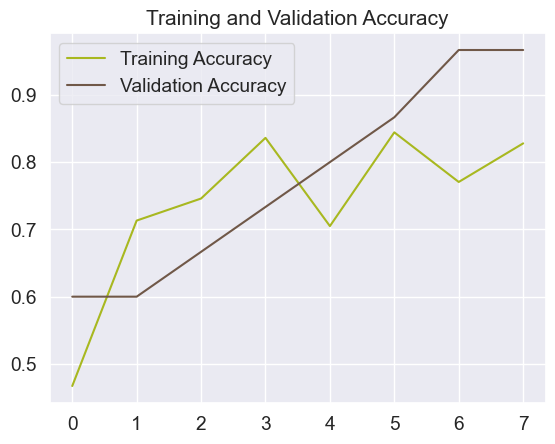

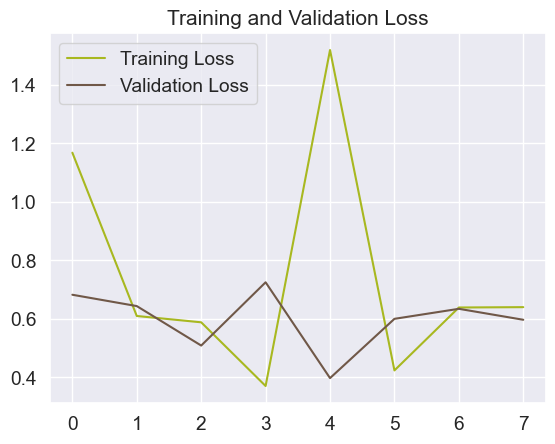

In [88]:
# Get accuracy history on train and testing data
acc = history.history['acc']
val_acc = history.history['val_acc']

# Get loss history on train and testin data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get num epochs
epochs = range(len(acc))

# Plot training v.s. test accuracy at each epoch
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training v.s. test loss at each epoch
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

## Validation Accuracy

In [107]:
# Get true labels
true_labels = val_data.labels

# Get model predictions
predictions = model.predict(val_data)

# Convert probabilities by thresholding
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# Count num correct and get misclassified filepaths
total = 0
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  total += 1
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))
print("Accuracy: " + str(1-(num_misclasssified/total)))

1/1 [==============================] - 0s 294ms/step
Model predictions: [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Actual labels:     [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
# of misclassified pokemon: 10
Accuracy: 0.6666666666666667


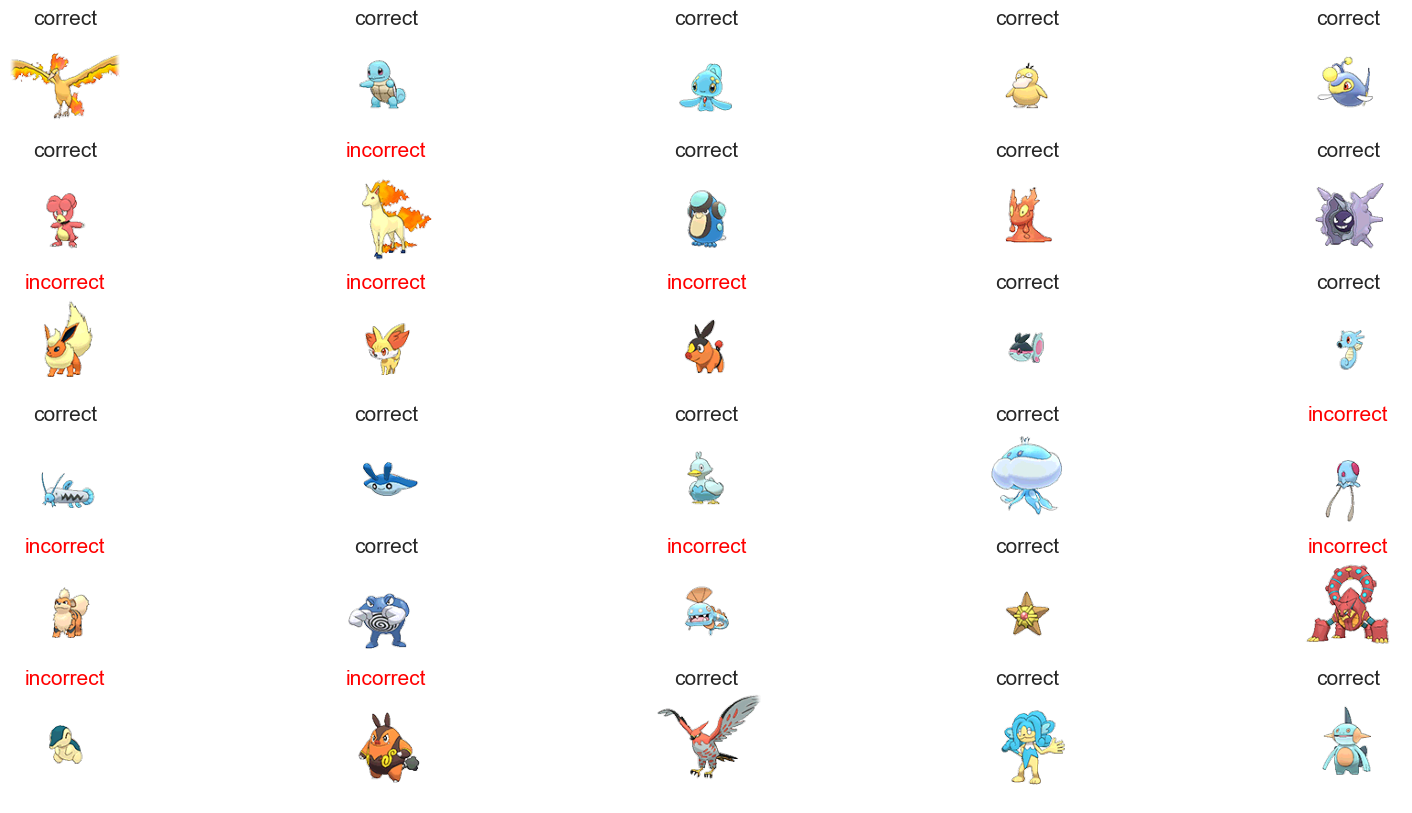

In [108]:
# Obtain images
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# Plot results
f, axarr = plt.subplots(6,5, figsize=(20,10))  
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()